# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


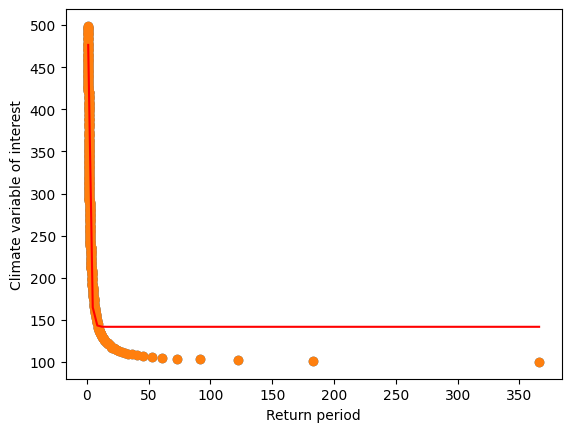

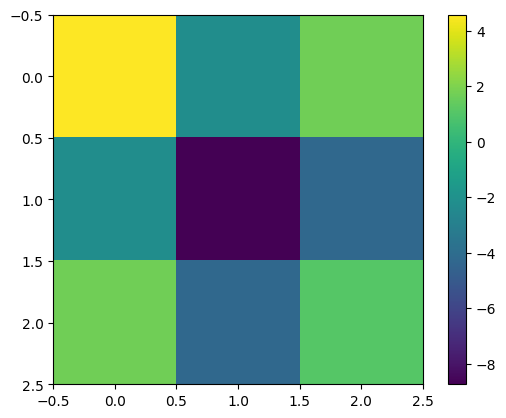

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset


import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement1 import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement1 import find_path_file
from FileManagement1 import find_column_name
from FileManagement1 import time_vector_conversion
from FileManagement1 import create_dataframe
from FileManagement1 import data_information
from FileManagement1 import df_to_csv
from FileManagement1 import read_nc_file

# Projects information


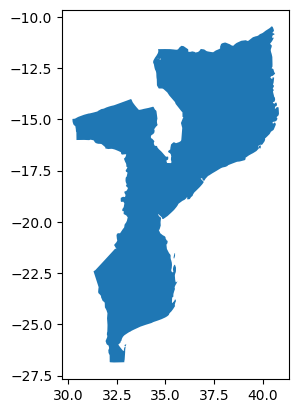

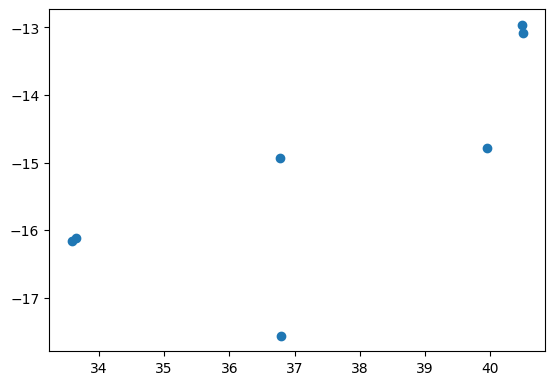

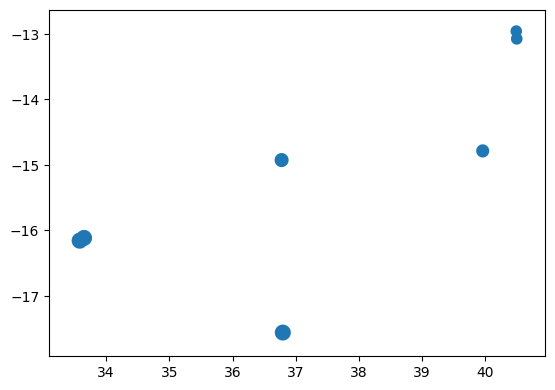

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = projects['Name'].str.replace('(','') # take off every ( of project names
name_project = projects['Name'].str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

In [3]:
len(lon_projects)

7

In [4]:
lon_projects

0    33.651626
1    33.582722
2    39.956305
3    36.776066
4    36.795077
5    40.487087
6    40.494835
dtype: float64

# Define Paths

In [5]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [6]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [7]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [8]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [9]:
len(url_list_precipitation)

2360

In [10]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [11]:
(year, year_str, index_year) = year_copernicus(2021,2022)

In [12]:
variables= []
time_aggregations= []
models= []
scenarios= []
for file_name in name_list_precipitation:
    (variable, time_aggregation, model, scenario, year) = data_information(file_name) 
    # use function data_information to find information concerning the file_name
    if variable not in variables:
        variables.append(variable)
    if time_aggregation not in time_aggregations:
        time_aggregations.append(time_aggregation)
    if model not in models:
        models.append(model)
    if scenario not in scenarios:
        scenarios.append(scenario)
title_file = variable +'_'+year_str[0] +'_'+year_str[len(year_str)-1]
name_variable = 'pr_day'

In [13]:
# count time

In [14]:
i = 0
df = pd.DataFrame() # create an empty dataframe
title_file = name_project[i]+'_2021-2022'+'.csv'
#area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
start = time.time()
df=create_dataframe(name_list_precipitation,'daily',year_str,[scenarios[0]],[models[0]],out_path, name_variable, name_project[i],lon_projects[0],lat_projects[0],df)
# return df and final path of csv
path_csv = df_to_csv(df,out_path,title_file,name_variable,'2021-2022')
end = time.time()
print('----- Time to execute the function create_dataframe with one model and one scenario: ' + str(end - start) +' seconds -------- ')
print('\n')

For the year 2021, test with scenario ssp245and with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc']
Registering the data in a dataframe
Time to execute the function get_data_nc for the variable pr: 7.7079083000026 seconds




Time to register one year in a dataframe: 1.510166300002311 seconds


Time to execute the function register_data: 9.493824599998334 seconds


For the year 2022, test with scenario ssp245and with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2022.nc']
Registering the data in a dataframe
Time to execute the function get_data_nc for the variable pr: 7.4551757000008365 seconds




Time to register one year in a dataframe: 1.7532547999981034 seconds


Time to execute the function register_data: 9.467894299999898 seconds


\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_file\pr_day2021-2022\PT_Revubue_2_(Rev_2_01)_2021-2022.csv
----- Time to execute the function create_dataframe with one model and one scenario: 19.135390

In [ ]:
df1 = pd.read_csv(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\csv_file\pr_day2021-2022\PT_Revubue_2_(Rev_2_01)_2021-2022.csv')

In [34]:
df.loc['PT_Revubue_2_(Rev_2_01)',('Longitude',33.625)]

Experiment  Model       Date        Latitude
ssp245      ACCESS-CM2  2021-01-01  -16.125     0.000059
                        2021-01-02  -16.125     0.000204
                        2021-01-03  -16.125     0.000088
                        2021-01-04  -16.125     0.000055
                        2021-01-05  -16.125     0.000058
                                                  ...   
                        2022-12-26  -16.125     0.000109
                        2022-12-27  -16.125     0.000000
                        2022-12-28  -16.125     0.000144
                        2022-12-29  -16.125     0.000000
                        2022-12-30  -16.125     0.000000
Name: (Longitude, 33.625), Length: 728, dtype: float32

In [37]:
df.loc[('PT_Revubue_2_(Rev_2_01)','ssp245'),('Longitude',33.625)]

Model       Date        Latitude
ACCESS-CM2  2021-01-01  -16.125     0.000059
            2021-01-02  -16.125     0.000204
            2021-01-03  -16.125     0.000088
            2021-01-04  -16.125     0.000055
            2021-01-05  -16.125     0.000058
                                      ...   
            2022-12-26  -16.125     0.000109
            2022-12-27  -16.125     0.000000
            2022-12-28  -16.125     0.000144
            2022-12-29  -16.125     0.000000
            2022-12-30  -16.125     0.000000
Name: (Longitude, 33.625), Length: 728, dtype: float32

In [38]:
df.loc[('PT_Revubue_2_(Rev_2_01)','ssp245')]

Longitude
                                  33.625
Model      Date       Latitude          
ACCESS-CM2 2021-01-01 -16.125   0.000059
           2021-01-02 -16.125   0.000204
           2021-01-03 -16.125   0.000088
           2021-01-04 -16.125   0.000055
           2021-01-05 -16.125   0.000058
...                                  ...
           2022-12-26 -16.125   0.000109
           2022-12-27 -16.125   0.000000
           2022-12-28 -16.125   0.000144
           2022-12-29 -16.125   0.000000
           2022-12-30 -16.125   0.000000

[728 rows x 1 columns]

In [ ]:
# Try augmentate efficiency of reading netcdf file

In [20]:
path_test = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6\pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc'

In [21]:
os.path.isfile(path_test)

True

In [40]:
Dataset(path_test).variables['pr'][:] # [:] gives a view of the Dataset, but give back masked data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [51]:
import xarray as xr

### Single netcdf file ###
ds =  xr.open_dataset(path_test)
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/22)
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T14:02:34.172359+00:00
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    ...                    ...
    history:               2021-10-04T14:02:34.172359+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0

In [62]:
type(ds)

xarray.core.dataset.Dataset

In [50]:
ds.notnull()

<xarray.Dataset>
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    pr       (time, lat, lon) bool False False False False ... False False False

In [55]:
precipitation = ds['pr']

In [59]:
test_precipitation_1=precipitation[1,1,1]

In [79]:
ds.pr.isel(time=0).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [80]:
type(ds.pr.isel(time=0).values)

numpy.ndarray

In [85]:
any(np.isnan(ds.pr.isel(time=0).values))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
k=0
for item in np.isnan(ds.pr.isel(time=100).values):
    for j in item:
        if not j:
            k+=1

In [92]:
k # not every values is a Nan

265272

In [94]:
len(ds.pr.isel(time=100,lat=1).values)

1440

In [76]:
ds.values()

ValuesView(<xarray.Dataset>
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/22)
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T14:02:34.172359+00:00
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    ...                    ...
    history:               2021-10-04T14:02:34.172359+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
   

In [78]:
float(ds.values())

TypeError: float() argument must be a string or a real number, not 'ValuesView'

In [53]:
import Nio

f = Nio.open_file(path_test, format="netcdf")
data = f.variables['MergedReflectivityQCComposite'][:]
f.close()

ModuleNotFoundError: No module named 'Nio'

In [ ]:
# 16 donnees pour chaque point si buf_projects = 0.5
# 1 si buf_projects = 0.1
# 9 si buf_projects = 0.3

# pourquoi certains files ne trouve pas leur model ???
i = 1
title_file = projects['Name'][i]+'_2021-2060'+'.csv'
area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [ ]:
# unit of the variable of interest
path_1 = os.path.join(out_path,name_list_precipitation[0])
Dataset(path_1).variables['pr'].units

In [ ]:
# resolution donnees ?
path_1 = os.path.join(out_path,name_list_precipitation[0])
Dataset(path_1) # resolution : 0.25 degree
lat_dataframe = np.ma.getdata(Dataset(path_1).variables['lat']).data # len = 600
lon_dataframe = np.ma.getdata(Dataset(path_1).variables['lon']).data # len = 1400

In [ ]:
resolution_lat=np.diff(lat_dataframe)
resolution_lat[resolution_lat!=0.25]

In [ ]:
resolution_lon = np.diff(lon_dataframe)
resolution_lon[resolution_lon!=0.25]

In [ ]:
from FileManagement import find_index_project
from FileManagement import find_column_name
column_name = find_column_name(path_1)
index_lat_project=find_index_project(lat_dataframe,area_projects[0][0],area_projects[1][0])
index_lon_project=find_index_project(lon_dataframe,area_projects[2][0],area_projects[3][0])
lat_dataframe =lat_dataframe[index_lat_project]
lon_dataframe =lon_dataframe[index_lon_project]

data_with_all = ma.getdata(Dataset(path_1).variables[column_name]).data

data_with_all=data_with_all[:,index_lat_project,:]
data_with_all=data_with_all[:,:,index_lon_project]

In [ ]:
data_with_all

In [ ]:
lat_dataframe

In [ ]:
import geopy.distance

coords_1 = (lat_dataframe[0], lon_dataframe[0]) # lat, lon
coords_2 = (lat_dataframe[1], lon_dataframe[1])

print(geopy.distance.geodesic(coords_1, coords_2).km)

In [ ]:
import geopy.distance

coords_1 = (lat_dataframe[2], lon_dataframe[2]) # lat, lon
coords_2 = (lat_dataframe[1], lon_dataframe[1])

print(geopy.distance.geodesic(coords_1, coords_2).km)

In [ ]:
# make one csv file for each projects
# create a new file name each time for each projet
for i in np.arange(0,len(projects['Name'])):
    title_file = projects['Name'][i]+'_2021-2060'
    area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
    create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [ ]:
type(scenarios)

In [ ]:
scenarios = [scenarios[0]]

In [ ]:
scenarios

In [ ]:
# make one csv file for each projects
# create a new file name each time for each projet
#for i in np.arange(0,len(projects['Name'])):
i = 1
scenarios = [scenarios[0]]
models = [models[0]]
title_file = projects['Name'][i]+'_2021-2060'
area_project = [area_projects[0][i],area_projects[1][i],area_projects[2][i],area_projects[3][i]]
create_dataframe(name_list_precipitation,'daily',year_str,scenarios,models,out_path, name_variable, projects['Name'][i],area_project,'2021-2060',title_file) 

In [ ]:
Datset

In [ ]:
# test with zonal_stats
from FunctionsAndClass import read_cckp_ncdata
import rioxarray
from rasterstats import zonal_stats
output = 'tempfile.tif'
with rioxarray.open_rasterio(path_1) as ncdata:
    ncdata.rio.write_crs('EPSG:4326', inplace=True)
    ncdata=ncdata.isel(time=0)
    data=ncdata.rio.to_raster(output)
#data=read_cckp_ncdata(path_1)
stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))

In [ ]:
path_1

In [ ]:
import netCDF4
import geopandas as gpd

# Path to the NetCDF file
nc_file = path_1

# Path to the shapefile
shapefile = project_location_path

# Open the NetCDF file
nc = netCDF4.Dataset(nc_file)

# Load the shapefile
gdf = gpd.read_file(shapefile)

# Extract coordinates from shapefile
points = gdf.geometry.centroid

# Get the variables from the NetCDF file
variable_names = nc.variables.keys()

# Iterate over the variables
for var_name in variable_names:
    var_data=np.ma.getdata(nc.variables['pr'][:]).data # Read the variable data
    # Iterate over the points in the shapefile
    for point in points:
        lon, lat = point.x, point.y

        # Find the corresponding indices in the NetCDF file
        #lon_index = netCDF4.chartostring(np.ma.getdata(nc.variables['lon'][:]).data).tolist().index(str(lon))
        #lat_index = netCDF4.chartostring(np.ma.getdata(nc.variables['lat'][:]).data).tolist().index(str(lat))
        
        lon_index = np.where(np.ma.getdata(nc.variables['lon'][:]).data < (lon + 0.1))
        lon_index = np.where(lon_index > (lon - 0.1))[1]
        
        lat_index = np.where(np.ma.getdata(nc.variables['lat'][:]).data < (lat + 0.1))
        lat_index = np.where(lat_index > (lat - 0.1))[1]

        #lat_index = np.where((np.ma.getdata(nc.variables['lat'][:]).data < (lat + 0.1)) and (np.ma.getdata(nc.variables['lat'][:]).data > (lat - 0.1)))#[0][0]

        
        # Extract the data at the specific lon/lat indices
        point_data = var_data[:, lat_index, lon_index]
        # Do whatever you want with the extracted data for each point
        print(f"Variable: {var_name}, Point: ({lon}, {lat}), Data: {point_data}")

# Close the NetCDF file
nc.close()

In [ ]:
lon_index[1]

In [ ]:
import netCDF4
import geopandas as gpd

# Path to the NetCDF file
nc_file = path_1

# Path to the shapefile
shapefile = project_location_path

# Open the NetCDF file
nc = netCDF4.Dataset(nc_file)

# Load the shapefile
gdf = gpd.read_file(shapefile)

# Extract coordinates from shapefile
points = gdf.geometry.centroid

# Get the variables from the NetCDF file
variable_names = nc.variables.keys()

In [ ]:
names_1=[]
for var_name in variable_names:
    print(type(var_name))
    names_1.append(var_name)
    data=nc.variables[var_name][:]

In [ ]:
names_1

In [ ]:
var_data=np.ma.getdata(nc.variables['time'][:]).data

In [ ]:
nc.variables['lon'][:]

In [ ]:
np.ma.getdata(nc.variables['lon'][:]).data

In [ ]:
Dataset(path_1).variables['pr'][0,0,0]

In [ ]:
lat